<div align="right"><i>Peter Norvig, 23 Oct 2017<br>Revised 2 June 2019</i></div>

# Bicycling: Speed versus Grade, VAM, Eddington Number, and H-index

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded all my recorded [Strava](https://www.strava.com/athletes/575579) rides longer than 25 miles as [`bikerides25.tsv`](bikerides25.tsv).  I parse the file into `rides`, a list of `Ride` structures. I filter out all the rides that have exactly 0 ft climbing (i.e. stationary bike rides) and that have `'MTB'` in the title (i.e. mountain bike rides that are not relevant to road bike riding).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import namedtuple

Ride = namedtuple('Ride', 'miles, hours, feet, date, title')

def parse_ride(line: str) -> Ride:
    """Parse a line from a Strava log file into a `Ride`. Line format is tab separated:
    Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft"""
    _, date, title, time, mi, ft = line.strip().split('\t')
    return Ride(number(mi), hours(*time.split(':')[::-1]), number(ft), date, title)

def number(string) -> float: return float(re.sub(r'[^0-9. ]', '', string))

def hours(sec, min, hour=0) -> float: return int(sec)/3600 + int(min)/60 + int(hour)

rides = [parse_ride(line) for line in open('bikerides25.tsv') 
         if 'MTB' not in line and '	0 ft' not in line]

I'll collect three interesting vectors of numbers: length of ride in miles, speed in miles per hour, grade in feet climbed per mile, and grade in percent. Then I'll start with a simple scatter plot  visualization:

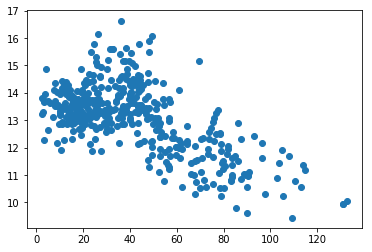

In [2]:
def vectors3(rides) -> tuple:
    "Return vectors of (miles, miles/hour, feet climbed per hour)"
    return ([r.miles           for r in rides],
            [r.miles / r.hours for r in rides],
            [r.feet  / r.miles for r in rides])

mls, mph, fpm = vectors3(rides)

plt.scatter(fpm, mph);

# Making it Prettier

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing the scatter plot, it looks like a curve would be a better fit than a straight line, so I'll fit a quadratic (degree two) polynomial to the data (for no good theoretical reason; just because that's the simplest nonlinear function I could think of). I'll also make the plot prettier and bigger:

In [3]:
def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', degree=2): 
    "Plot X versus Y and a best fit curve to it, with some bells and whistles."
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.style.use('fivethirtyeight')
    plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.scatter(X, Y)   
    F = poly_fit(X, Y, degree)
    X1 = sorted(set(X))
    plt.plot(X1, [F(x) for x in X1], 'k:')
    
def poly_fit(X, Y, degree) -> callable:
    """The polynomial function that best fits the X,Y vectors."""
    coeffs = np.polyfit(X, Y, degree)[::-1]
    return lambda x: sum(c * x ** i for i, c in enumerate(coeffs))

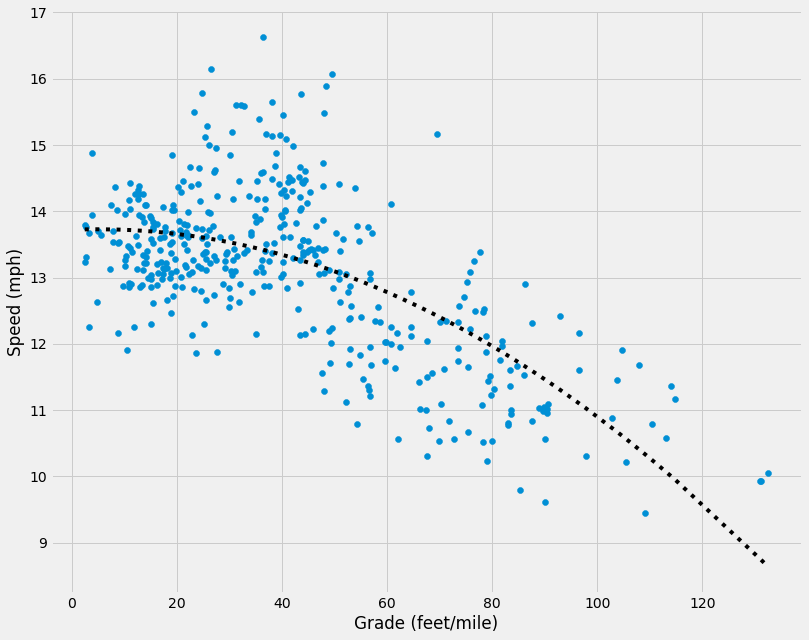

In [4]:
show(fpm, mph)

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But from around 50 ft/mile grade speed falls off quickly: down to 12mph at 80 ft/mile;  11 mph at 100 ft/mile; and under 9 mph at 130 ft/mile. Note that even 130 ft/mile is only 2.5% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flat, then that's 7.5% grade on the up part.

# Estimating Duration

This data can help me predict how long will it take to ride a route with a given distance and elevation. For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 344 ft climb), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 735 ft climb); which is faster?

In [5]:
def duration(dist, climb, F=poly_fit(fpm, mph, 2)) -> float:
    "Given a distance in miles and total climb in feet, estimate time in minutes."
    return 60 * dist / F(climb / dist)

In [6]:
duration(15.7, 344), duration(13.5, 735)

(69.06919916201585, 62.49077357120634)

This suggests the shorter creek route would be about 6 or 7 minutes faster. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Segments

The data I have so far helps me estimate the duration for a long ride over varying up-and-down terrain. But what if I just want to know how long it will take to climb the next hill? To answer that I'll go back to Strava and retrieve data from individual segments, some only a fraction of a mile long, some several miles long, but most with a relatively constant grade. I picked some representative climbing segments ([`bikesegments.csv`](bikesegments.csv)) with the segment length in miles and climb in feet, along with several of my times on the segment. (I picked the first, midde, and last of the rides shown by Strava&mdash;the 10 fastest rides.)

In [7]:
def parse_segments(lines):
    """Parse a string of segments into Rides. Each line contains:
    'title, miles, feet, time,*'."""
    for segment in lines:
        title, mi, ft, *times = segment.split(',')
        for time in times:
            yield Ride(float(mi), hours(*time.split(':')[::-1]), int(ft), '?', title)
            
segments = list(parse_segments(open('bikesegments.csv')))

mls2, mph2, fpm2 = vectors3(segments)     

Now I plot this data, this time using a third-degree polynomial, just because it seems to fit better, and listing grade in percent rather than feet per mile:

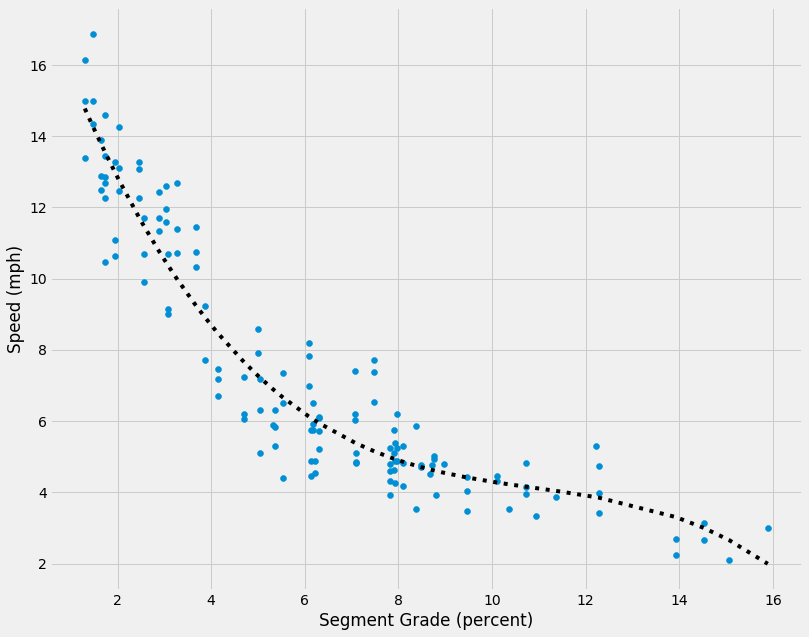

In [8]:
pct2 = [f * 100 / 5280 for f in fpm2]

show(pct2, mph2, xlabel='Segment Grade (percent)', degree=3)  

So I can cruise at 17 mph on a 1% grade, but only a bit over 6 mph at 6% grade, and around 5 mph on 8% grades.

# VAM

The number of vertical feet climbed per hour (regardless of horizontal distance travelled) is known as [VAM](https://en.wikipedia.org/wiki/VAM_(bicycling)), which stands for *velocità ascensionale media* (when you have Campagnolo components) or *mean ascent velocity* (on SRAM) or 平均上昇率 (on Shimano). Legend has it that at grades between about 6% to 12%, most of your power is going into lifting against gravity, so your VAM should be about constant no matter what the grade in that range. (I guess that below that grade, power is spent on wind and rolling resistance, and above it, power goes largely to cursing *sotto voce*, as they say in Italian.) Here's a plot of my VAM at various grades:

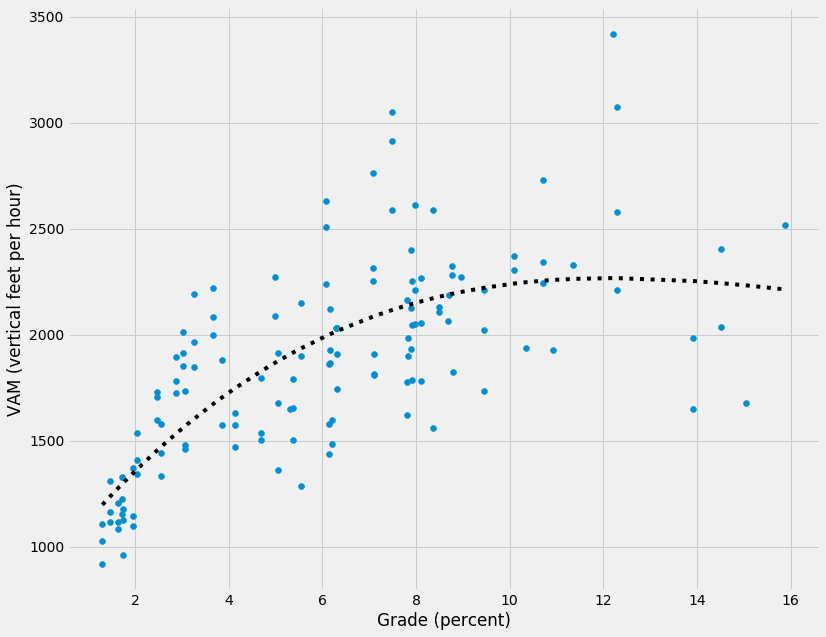

In [9]:
vam2 = [r.feet / r.hours for r in segments]

show(pct2, vam2, xlabel='Grade (percent)', ylabel='VAM (vertical feet per hour)', degree=3)

I don't really get that flat effect; my numbers are widely spread out. This does confirm that I'm an average club climber at about 2000 ft/hour; champion climbers can do 5,000 or even 6,000 feet per hour.

# Eddington Number

The British physicist Sir Arthur Eddington (1882-1944) was a pre-Strava bicyclist who favored this metric:

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the maximum number**&nbsp;E** such that you have bicycled**&nbsp;E** or more miles on**&nbsp;E** or more days.*

Let's calculate mine, and see how many rides I need  to improve it. For various number of miles, I'll list the number of rides of at least that long that I've taken, and the *gap*&mdash;the number of additional rides I would need to reach that Eddington number.

In [10]:
def eddington(distances, unit='Mi', gaps=range(-1, 41)):
    """Print the number of days doing various distances, and the Eddington gap."""
    print(f'{unit} Days Gap')
    print(f'-- ---- ---')
    for E in range(1, 200):
        days = sum(d >= E for d in distances)
        gap  = E - days
        if gap in gaps:
            print(f'{E:2}  {days:2}  {gap:2}')

In [11]:
eddington(mls, 'Mi')

Mi Days Gap
-- ---- ---
53  54  -1
54  51   3
55  49   6
56  48   8
57  45  12
58  42  16
59  37  22
60  36  24
61  30  31
62  28  34
63  26  37
64  24  40


So my **Eddington Number is 53**: I've done 53 miles or more on 54 days, but 54 miles I've done on only 51 days. This happens to be right around [the mean for Strava users](https://swinny.net/Cycling/-4687-Calculate-your-Eddington-Number). To increase that number by 5 to 58, obviously I would need at least 5 rides, but it turns out I would actually need 16 (because 11 rides were between 53 and 57 miles).  Eddington was about my age when he died with a number of **77**, and his available roads and bicycles were not nearly as nice as mine, so good for him.

If 53 seems too small a number, we can use kilometers instead of miles:

In [12]:
kms = [m * 5280 * 12 * 2.54 / 100 / 1000 for m in mls]
eddington(kms, 'Km')

Km Days Gap
-- ---- ---
76  77  -1
77  76   1
78  74   4
79  73   6
80  72   8
81  69  12
82  61  21
83  60  23
84  55  29
85  54  31
86  53  33
87  51  36
88  50  38
89  49  40


My **metric Eddington Number is 76**, and to increase by 5 to 81 I  would need 12 more rides.

# H-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications (and  by Eddington's h-index-like number), I invented a new h-index, or hill-index:

> *Your **h-index** is the maximum number**&nbsp;H** for which you can regularly climb an**&nbsp;H** percent grade at **&nbsp;H** miles per hour.*

I think **my h-index is 6**, but let's draw a plot to confirm:

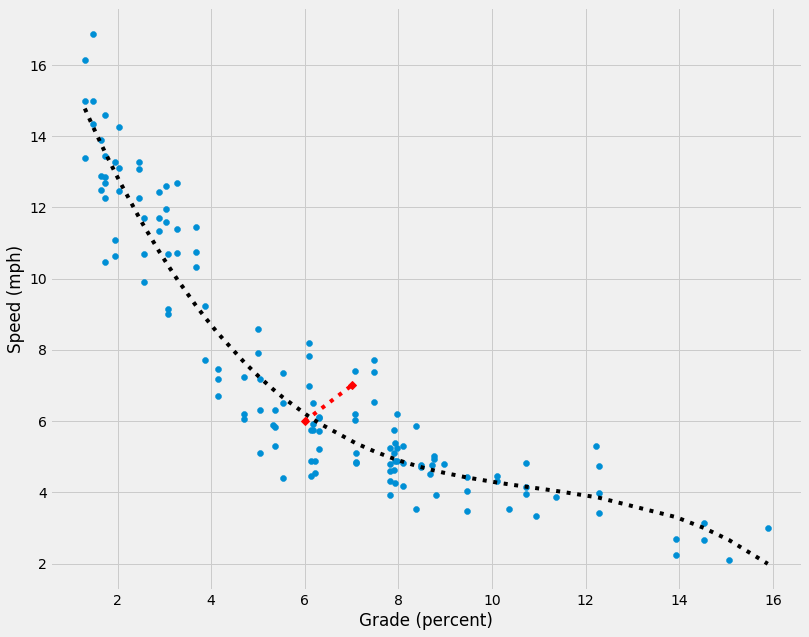

In [13]:
show(pct2, mph2, xlabel='Grade (percent)', degree=3)  
plt.plot([6, 7], [6, 7], 'rD:');

My guess is confirmed: the leftmost red diamond indicates 6 mph at 6% grade, and we can see that my speed curve (dotted black line) is above that point (looks like about 6.2 mph at 6%), but I can't reach 7 mph at 7% (at least not *regularly,* according to the curve; the one outlier point at 7.5 mph at 7% doesn't count.). 